# Figure 2. Cross-sectional effect of age on excitation-inhibition ratio during adolescence

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
import pickle
import statsmodels.stats.multitest
import sklearn.utils
from tqdm import tqdm

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)

from utils import transform, plot
from modeling.check_fit import load_cmaes

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 16, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = "#44546A"

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Load optimal simulations, demographics and other data needed:

In [3]:
itMax = 81
lmbda = 210
params = {
    "G": "0.5-4",
    "wee": "0.05-0.75",
    "wei": "0.05-0.75",
    "wie": "0",
}
het_params = "wee-wei"
n_vols_remove = 10  # = 30s

elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "pnc_subs.csv"), index_col=0
).sort_index()
parcels = transform.load_ordered_parcel_labels("schaefer-100")

In [4]:
if os.path.exists("pnc_optima.csv") & os.path.exists("pnc_vars.pkz"):
    # load pre-curated data if it exists
    subjects_optima = pd.read_csv("pnc_optima.csv", index_col=0)
    with open("pnc_vars.pkz", "rb") as f:
        regional_vars = pickle.load(f)
else:
    subjects_optima = []
    regional_vars = {}
    for sub in tqdm(elig_subs.index):
        cmaes_dir = os.path.join(
            OUTPUT_DIR["pnc"], 'sim', sub, 
            'ctx_parc-schaefer-100_mean001_thresh-1', 
            '6maps_schaefer-100_zscore',
            'cmaes_multimaps_gpu'
        )
        sims_dir = cmaes_dir.replace("cmaes_multimaps_gpu", "sims_multimaps_gpu")
        sc_path = os.path.join(
            OUTPUT_DIR["pnc"], 'SC', sub,
            'ctx_parc-schaefer-100_mean001_thresh-1_desc-strength.txt'
        )
        emp_fc_tril_path = os.path.join(
            OUTPUT_DIR["pnc"], 'FC', sub,
            'ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_desc-FCtril.txt'
        )
        emp_fcd_tril_path = emp_fc_tril_path.replace('FCtril', 'FCDtril')
        emp_fc_tril = np.loadtxt(emp_fc_tril_path)
        emp_fcd_tril = np.loadtxt(emp_fcd_tril_path)
        regional_vars[sub] = {}
        for SeedMW in [1, 2]:
            cmaes_res = load_cmaes(
                cmaes_dir,
                sims_dir,
                params,
                het_params,
                emp_fc_tril,
                emp_fcd_tril,
                sc_path=sc_path,
                n_vols_remove=n_vols_remove,
                itMax=itMax,
                lmbda=lmbda,
                SeedMW=SeedMW,
                dataset="pnc",
            )
            if cmaes_res:
                cmaes_res[0]["sub"] = sub
                cmaes_res[0]["SeedMW"] = SeedMW
                subjects_optima.append(cmaes_res[0])
                regional_vars[sub][SeedMW] = cmaes_res[1]
    subjects_optima = pd.DataFrame(subjects_optima)
    subjects_optima.to_csv("pnc_optima.csv")
    with open("pnc_vars.pkz", "wb") as f:
        pickle.dump(regional_vars, f)

Select the best run in each subject and add the demographics and motion measures to the data:

In [5]:
best_runs = subjects_optima.groupby("sub")["gof"].idxmax().values
data = subjects_optima.loc[best_runs].set_index("sub")
data[["age", "sex"]] = elig_subs.loc[data.index, ["age", "sex"]]
data["Age (y)"] = data["age"] / 12

# add motion data
motion = pd.read_csv(
    os.path.join(OUTPUT_DIR["pnc"], 'postfmriprep', 'participants.tsv'), 
    delimiter="\t", index_col=0
).loc[data.index]
data = pd.concat([data, motion], axis=1)
data.to_csv("pnc_data.csv")

Create a dataframe of regional $\langle I^E \rangle$ in each subject:

In [6]:
I_E = pd.DataFrame(index=data.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for sub, row in data.iterrows():
        I_E.loc[sub, parc] = regional_vars[sub][row["SeedMW"]].loc[i, "I_E"]
I_E.to_csv("pnc_IE.csv")

Apply the linear regression model:

In [7]:
df = pd.concat([I_E, data], axis=1)
df.columns = [f"node_{i}" for i in range(100)] + list(df.columns[100:])

t_age = pd.Series(index=parcels)
r_age = pd.Series(index=parcels)
p_age = pd.Series(index=parcels)
Ns = pd.Series(index=parcels)

for i, parc in enumerate(parcels):
    # exclude outliers
    curr_subs = I_E.index[(scipy.stats.zscore(I_E.loc[:, parc]).abs() < 3)]
    model_df = df.loc[curr_subs]
    # fit the confound removal model to calculate pearson's r of the
    # residual of I_E with age as an easy-to-interpret effect size
    res_conf = smf.ols(f"node_{i} ~ gof + sex + mean_rms", data=model_df).fit()
    r_age.loc[parc] = scipy.stats.pearsonr(model_df["age"], res_conf.resid).statistic
    # fit the main model
    mod = smf.ols(f"node_{i} ~ age + gof + sex + mean_rms", data=model_df)
    res = mod.fit()
    t_age.loc[parc] = res.tvalues["age"]
    p_age.loc[parc] = res.pvalues["age"]
    Ns.loc[parc] = len(curr_subs)

# FDR correction
_, p_age_fdr = statsmodels.stats.multitest.fdrcorrection(p_age)
p_age_fdr = pd.Series(p_age_fdr, index=parcels)

# save stats and display stats of signficant regions
stats_age = pd.DataFrame({"t": t_age, "r": r_age, "p": p_age, "p_fdr": p_age_fdr, "N": Ns})
stats_age.to_csv("p_pnc_fc-sub_sc-sub_runs-2_IE_age_stats.csv")
stats_age[stats_age["p_fdr"] < 0.05].sort_values(by="t").round(3)

,t,r,p,p_fdr,N
7Networks_RH_Cont_Par_1,-7.330,-0.255,0.000,0.000,745.0
7Networks_LH_Cont_pCun_1,-6.957,-0.242,0.000,0.000,746.0
7Networks_RH_Cont_PFCl_1,-6.946,-0.243,0.000,0.000,741.0
7Networks_RH_Default_Par_1,-6.342,-0.222,0.000,0.000,749.0
7Networks_RH_Cont_PFCl_4,-6.133,-0.215,0.000,0.000,748.0
7Networks_RH_Default_PFCdPFCm_3,-5.987,-0.211,0.000,0.000,745.0
7Networks_RH_Cont_Par_2,-5.750,-0.204,0.000,0.000,738.0
7Networks_LH_Limbic_OFC_1,-5.253,-0.187,0.000,0.000,739.0
7Networks_LH_Default_PFC_3,-5.158,-0.183,0.000,0.000,739.0
7Networks_LH_Default_PFC_7,-5.144,-0.182,0.000,0.000,746.0


## A. Effect of age on E-I ratio (FDR-corrected)

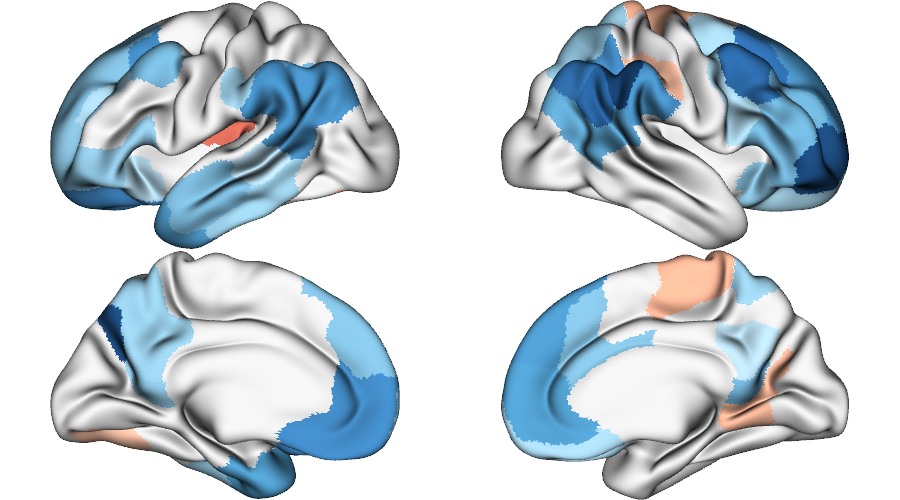

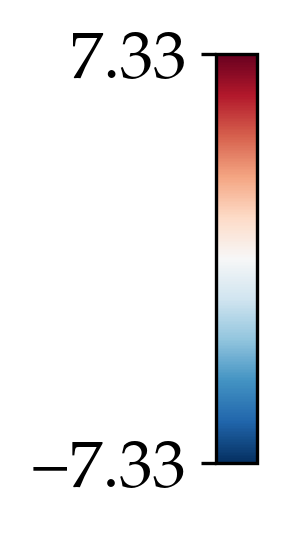

In [8]:
vmin = min(t_age.values.min(), -t_age.values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(
        t_age[p_age_fdr < 0.05], "schaefer-100", concat=True, space="fsaverage"
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style="grid",
    # filename='./figures/2A.svg'
)

## B. Effect of age on E-I ratio (unthresholded)

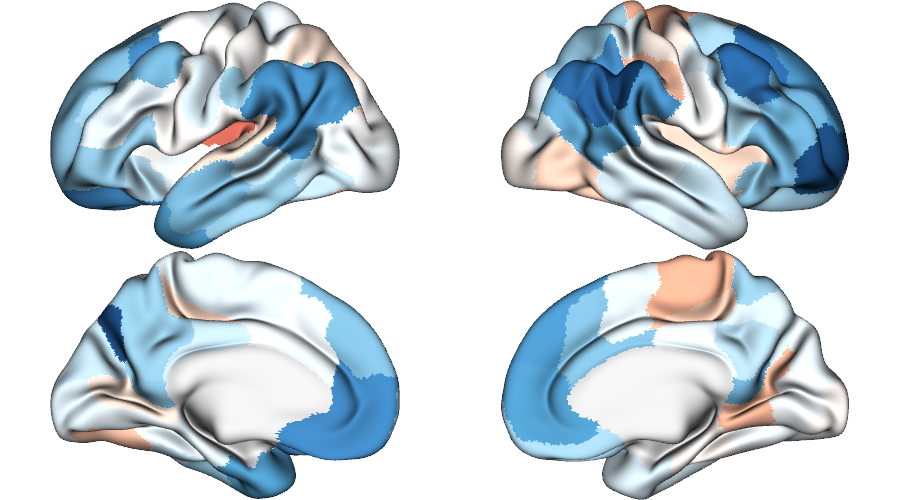

In [9]:
plot.plot_surface(
    transform.deparcellate_surf(t_age, "schaefer-100", concat=True, space="fsaverage"),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange=(vmin, vmax),
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
    # filename='./figures/2B.svg'
)

## C. Stability of age effect map across subsamples of subjects

Calculate age effects in 100 half-split subsamples of subjects:

In [17]:
# add age bin to stratify subsamples based on age and sex
df["age_bin"] = pd.cut(df["Age (y)"], 10)

n_subsamples = 100
n_samples = df.shape[0] // 2
print("Using n_samples", n_samples)

t_subsamples = pd.DataFrame(index=parcels, columns=range(n_subsamples), dtype=float)
p_subsamples = pd.DataFrame(index=parcels, columns=range(n_subsamples), dtype=float)

for subsample in tqdm(range(n_subsamples)):
    # creating half-split subsamples without replacement
    # using subsample index as random_state for reproducibility
    subsample_df = sklearn.utils.resample(
        df,
        replace=False,
        n_samples=n_samples,
        random_state=subsample,
        stratify=df[["sex", "age_bin"]],
    )
    # calculate age effect in current subsample
    for i, parc in enumerate(parcels):
        curr_subs = subsample_df.index[
            (scipy.stats.zscore(subsample_df.loc[:, f"node_{i}"]).abs() < 3)
        ]
        model_df = subsample_df.loc[curr_subs]
        mod = smf.ols(f"node_{i} ~ age + gof + sex + mean_rms", data=model_df)
        res = mod.fit()
        t_subsamples.loc[parc, subsample] = res.tvalues["age"]
        p_subsamples.loc[parc, subsample] = res.pvalues["age"]

Using n_samples 376


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


Calculate and plot the correlation between age effect maps calculated across subsamples:

In [18]:
subsamples_corr = np.corrcoef(t_subsamples.values.T)
subsamples_corr = subsamples_corr[np.tril_indices_from(subsamples_corr, -1)]

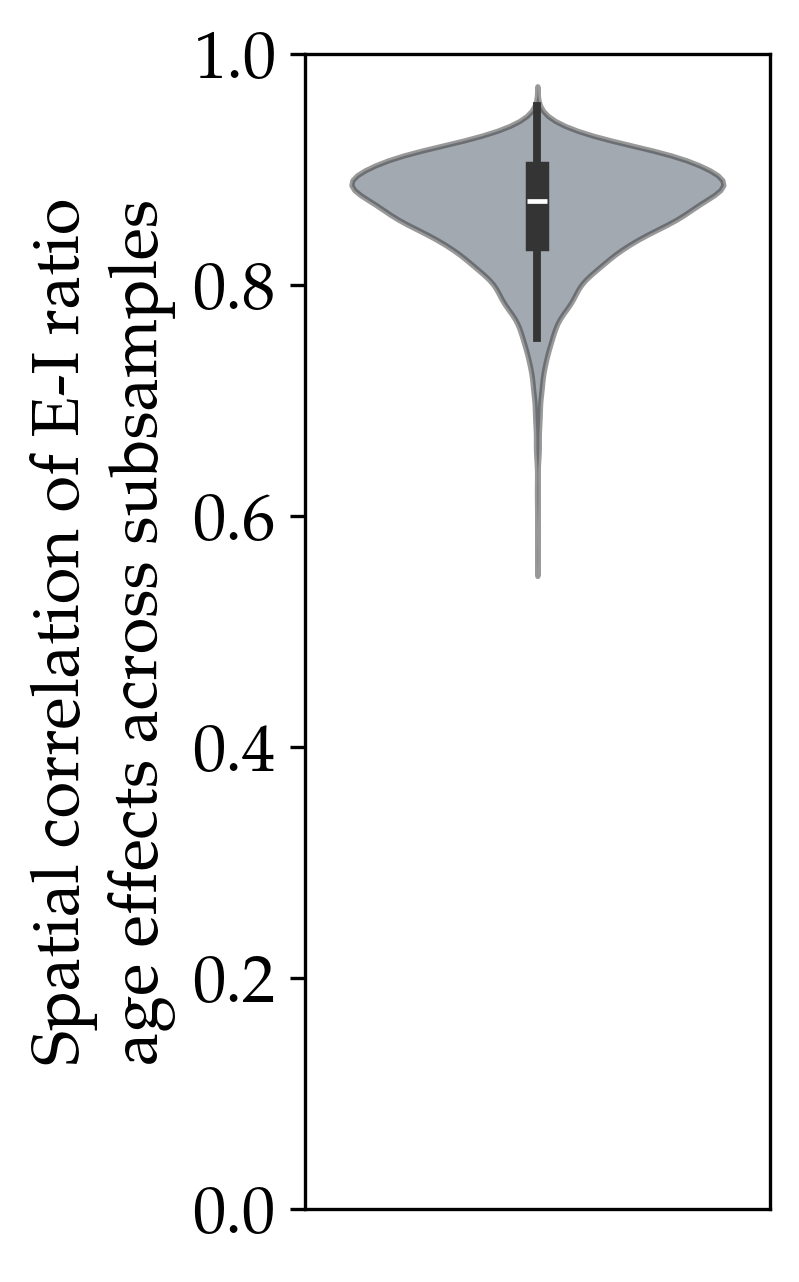

In [19]:
fig, ax = plt.subplots(figsize=(2, 5))
sns.violinplot(y=subsamples_corr, color=thcolor, inner='box', alpha=0.5, ax=ax)
ax.set_ylabel(
    "Spatial correlation of E-I ratio\nage effects across subsamples"
)
ax.set_ylim([0, 1])
ax.set_xticks([])
# fig.savefig('./figures/2C.svg', bbox_inches='tight', pad_inches=0, dpi=1200)

In [20]:
pd.Series(subsamples_corr).describe()

count    4950.000000
mean        0.863443
std         0.046771
min         0.565003
25%         0.839607
50%         0.872839
75%         0.896785
max         0.954899
dtype: float64

## Text. Age-by-sex intercation

In [21]:
t_age_sex = pd.Series(index=parcels, dtype=float)
p_age_sex = pd.Series(index=parcels, dtype=float)
for i, parc in enumerate(parcels):
    curr_subs = df.index[(scipy.stats.zscore(df.loc[:, f'node_{i}']).abs() < 3)]
    model_df = df.loc[curr_subs]
    mod = smf.ols(f'node_{i} ~ sex*age + gof + mean_rms', data=model_df)
    res = mod.fit()
    t_age_sex.loc[parc] = res.tvalues['sex[T.M]:age']
    p_age_sex.loc[parc] = res.pvalues['sex[T.M]:age']

# FDR correction
_, p_age_sex_fdr = statsmodels.stats.multitest.fdrcorrection(p_age_sex)
p_age_sex_fdr = pd.Series(p_age_sex_fdr, index=parcels)

# display effect of signficant regions
t_age_sex[p_age_sex_fdr<0.05].sort_values()

Series([], dtype: float64)